# Dark Channel Prior

In [10]:
import math
import numpy as np
import pandas as pd
import cv2
import time
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

In [11]:
class Node(object):
    def __init__(self,x,y,value):
        self.x = x
        self.y = y
        self.value = value

    def printInfo(self):
        print('%s:%s:%s' %(self.x,self.y,self.value))

In [12]:
#check if image shape is fine i.e. there are 3 channels
#returns min of three channels
def getMinChannel(img):
    '''gets min in val in differnt channel
    Parameters:
        img(numpy array): input image
    Returns:
        min in three channels'''
    if len(img.shape)==3 and img.shape[2]==3:
        pass
    else:
        print("bad image shape, input must be color image")
        return None
    
    return np.min(img, axis=2)

In [13]:
def getDarkChannel(img,blockSize = 3):
    '''
    Gets dark channel
    Parameters:
        image(numpy array): Input image
        blockSize(int):neighbourhood Refered to as omega in paper
    Return:
        image:Dark channel only one channel
    '''
    
    if len(img.shape)==2:
        pass
    else:
        print("bad image shape, input image must be two demensions")
        return None

    
    if blockSize % 2 == 0 or blockSize < 3:
        print('blockSize is not odd or too small')
        return None

    
    A = int((blockSize-1)/2) #Define increments around centre of the block

    #New height and new width
    H = img.shape[0] + blockSize - 1
    W = img.shape[1] + blockSize - 1

    #define padding
    imgMiddle = 255 * np.ones((H,W))    

    imgMiddle[A:H-A, A:W-A] = img
    
    imgDark = np.zeros_like(img, np.uint8)    
    
    localMin = 255
    #define neighbourhood
    for i in range(A, H-A):
        for j in range(A, W-A):
            x = range(i-A, i+A+1)
            y = range(j-A, j+A+1)
            #defines darkest pix in neighbourhood
            imgDark[i-A,j-A] = np.min(imgMiddle[x,y])                            
            
    return imgDark


In [14]:
def getAtomsphericLight(darkChannel,img,meanMode = False, percent = 0.001):
    '''
    Gets estimate for for factor A in transmission map
    Parameters:
        darkChannel(1-D numpy array): Dark channel obtained from getDarkChannel()
        img(3-d numpy array): input image
        percent(float): percent of pixels to be considered for A calculation
    Returns atmosphericLight(float): value of term A
    '''
    size = darkChannel.shape[0]*darkChannel.shape[1]
    height = darkChannel.shape[0]
    width = darkChannel.shape[1]

    nodes = []

    #list of pixel location and darkchannel intensity location
    for i in range(0,height):
        for j in range(0,width):
            oneNode = Node(i,j,darkChannel[i,j])
            nodes.append(oneNode)	

    #sort nodes in descending order of dark channel intensity
    nodes = sorted(nodes, key = lambda node: node.value,reverse = True)

    atomsphericLight = 0

    # top value of img as atmospheric light
    if int(percent*size) == 0:
        for i in range(0,3):
            if img[nodes[0].x,nodes[0].y,i] > atomsphericLight:
                atomsphericLight = img[nodes[0].x,nodes[0].y,i]
        return atomsphericLight

    
    if meanMode:
        sum = 0
        for i in range(0,int(percent*size)):
            for j in range(0,3):
                sum = sum + img[nodes[i].x,nodes[i].y,j]
        atomsphericLight = int(sum/(int(percent*size)*3))
        return atomsphericLight

   
    for i in range(0,int(percent*size)):
        for j in range(0,3):
            if img[nodes[i].x,nodes[i].y,j] > atomsphericLight:
                atomsphericLight = img[nodes[i].x,nodes[i].y,j]
    return atomsphericLight


In [15]:
def getRecoverScene(img, omega=0.95, t0=0.1, blockSize=15, meanMode=False, percent=0.001, refine=False):
    '''
    get recovered scene from dark channel prior
    Parameters:
        img(3d numpy array): input image
        omega(float): for incomplete haze removal to aid in depth perception
        t0(float): lower bount for t
        blocksize(int): neighbourhood size
        percent: number of pixeks to consider for Atmosheric light determination
    Return:
    sceneRadiance(3 d numpy array): recovered image
    '''
    imgGray = getMinChannel(img)
    imgDark = getDarkChannel(imgGray, blockSize = blockSize)
    atomsphericLight = getAtomsphericLight(imgDark,img,meanMode = meanMode,percent= percent)

    imgDark = np.float64(imgDark)
    transmission = 1 - omega * imgDark / atomsphericLight

    transmission[transmission<0.1] = 0.1     
    
    if refine:        
        normI = (img - img.min()) / (img.max() - img.min())  # normalize I
        transmission = guided_filter(normI, transmission, r=40, eps=1e-3)

    sceneRadiance = np.zeros(img.shape)
    img = np.float64(img)
    
    for i in range(3):        
        SR = (img[:,:,i] - atomsphericLight)/transmission + atomsphericLight

                        
        SR[SR>255] = 255
        SR[SR<0] = 0                    
        sceneRadiance[:,:,i] = SR  
            
    sceneRadiance = np.uint8(sceneRadiance)

    return sceneRadiance

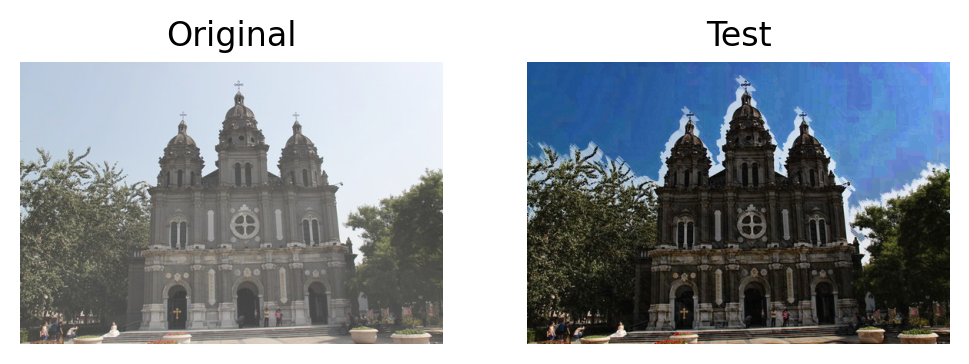

In [17]:
def sample():
    url="https://raw.githubusercontent.com/abubakrsiddq/ImageDehazing/main/sampleImg/hazy/1982_1_0.08.jpg"
    image = io.imread(url) 
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #img = cv2.imread('./hazy/0001_0.8_0.2.jpg',cv2.IMREAD_COLOR)
    sceneRadiance = getRecoverScene(img)
    
    plt.rcParams['figure.dpi'] = 200
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(sceneRadiance, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Test")
    #cv2.imshow('original',img)
    #cv2.imshow('test',sceneRadiance)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

sample()